
**Using to_catagorical for masks and np.expand_dim for images to match the dimensions for both, image and mask arrays. Finally applied 3d Segnet as 2D segnet can handel max upto 4 dimention but here we have 5 dimentions. Still getting OOM error**

In [1]:
import numpy as np
import nibabel as nib
import glob
#from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
x_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/train_images.npy')
x_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_images.npy')
y_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/train_masks.npy')
y_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_masks.npy')

In [3]:
import tensorflow as tf


In [4]:
y_train_catagorical = tf.keras.utils.to_categorical(y_train)
y_test_catagorical = tf.keras.utils.to_categorical(y_test)

In [6]:
xtrain_expanded = np.expand_dims(x_train, axis = 4)
xtest_expanded = np.expand_dims(x_test, axis = 4)

In [7]:
xtrain_expanded.shape, xtest_expanded.shape

((168, 128, 128, 128, 1), (42, 128, 128, 128, 1))

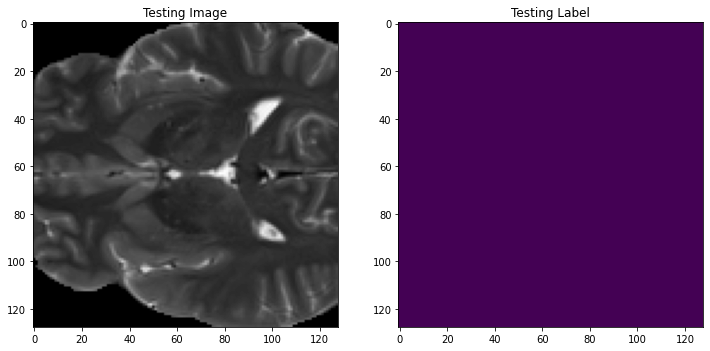

In [8]:
n_slice = 56

image = 51

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(xtrain_expanded[image,:,:,n_slice,0], cmap = "gray")
plt.subplot(122)
plt.title('Testing Label')
plt.imshow(y_train[image,:,:,n_slice])

plt.show()

In [9]:
from keras.models import Model,Sequential
import numpy as  np
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, merge, Conv2D,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, Callback
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.python import keras
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras.layers import Conv3D, MaxPooling3D, concatenate, UpSampling3D
%matplotlib inline

In [10]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


In [ ]:
!pip install keras_applications
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

In [12]:
import numpy as np


########################
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers import BatchNormalization
import tensorflow as tf
from torch.nn import MaxUnpool3d
from keras.layers import Conv3D, MaxPooling3D, concatenate, UpSampling3D


def segnet(
        input_shape = (128,128,128,1),
        n_labels = 4,
        kernel=3,
        pool_size=(2, 2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Conv3D(64, (kernel, kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv3D(64, (kernel, kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1= MaxPooling3D(pool_size)(conv_2)

    conv_3 = Conv3D(128, (kernel, kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv3D(128, (kernel, kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling3D(pool_size)(conv_4)

    conv_5 = Conv3D(256, (kernel, kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3 = MaxPooling3D(pool_size)(conv_7)

    conv_8 = Conv3D(512, (kernel, kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4 = MaxPooling3D(pool_size)(conv_10)

    conv_11 = Conv3D(512, (kernel, kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5 = MaxPooling3D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = UpSampling3D(pool_size)(pool_5)

    conv_14 = Conv3D(512, (kernel, kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = UpSampling3D(pool_size)(conv_16)

    conv_17 = Conv3D(512, (kernel, kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv3D(512, (kernel, kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling3D(pool_size)(conv_19)

    conv_20 = Conv3D(256, (kernel, kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv3D(256, (kernel, kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv3D(128, (kernel, kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = UpSampling3D(pool_size)(conv_22)

    conv_23 = Conv3D(128, (kernel, kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv3D(64, (kernel, kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = UpSampling3D(pool_size)(conv_24)

    conv_25 = Conv3D(64, (kernel, kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv3D(n_labels, (1, 1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    '''conv_26 = Reshape(
            (input_shape[0]*input_shape[1], n_labels),
            input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)'''

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")
    model.compile(optimizer= Adam(learning_rate=0.001, decay=0.05), loss= ["binary_crossentropy"]
            , metrics=[iou, dice_coef, precision, recall, accuracy])
    return model



model = segnet(input_shape=(128,128,128,1), n_labels=4)

model.summary()
print(model.input_shape)
print(model.output_shape)

Build enceder done..
Build decoder done..
Model: "SegNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 128, 64) 1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128, 64) 256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128, 64) 0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 128, 64) 110656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128, 64) 256       
_________________________________________________________________
activation_1 (Acti

In [42]:
model.compile(optimizer= Adam(learning_rate=0.001, decay=0.05), loss= ["binary_crossentropy"]
            , metrics=[iou, dice_coef, precision, recall, accuracy])

In [13]:
model = segnet()#'segnet_1_epoch.h5')
#model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
hist = model.fit(xtrain_expanded, y_train_catagorical, epochs= 100, batch_size= 2, validation_data= (xtest_expanded, y_test_catagorical), verbose=1)

Build enceder done..
Build decoder done..
Epoch 1/100


ResourceExhaustedError: ignored

In [14]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [33]:
prediction = model.predict(x_test)

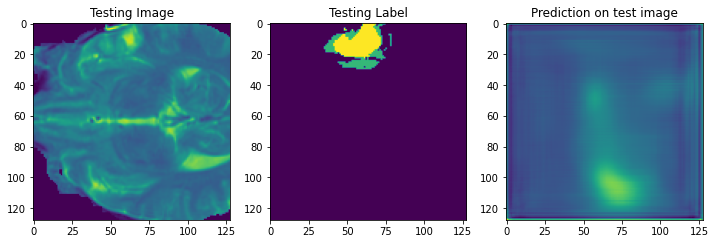

In [36]:
n_slice = 50

image = 32

plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(x_test[image,:,:,n_slice])
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(y_test[image,:,:,n_slice])
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction[image,:,:,n_slice])
plt.show()